In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os.path import expanduser
from scipy.stats import wasserstein_distance as wd

from data_converge.util import data_utils as du


%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# Load prediction data
experiment_path = '/work/projects/SD2E-Community/prod/projects/sd2e-project-43/reactor_outputs/preview/'
experiment_dataset = 'YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Dose-Response/20200721121652'
experiment_df = du.get_data_and_metadata(experiment_path + experiment_dataset)

In [2]:
print(experiment_dataset)
print(experiment_df.shape)
print(experiment_df.columns)

YeastSTATES-Beta-Estradiol-OR-Gate-Plant-TF-Dose-Response/20200721121652
(16964677, 80)
Index(['_id', 'sample_id', 'experiment_reference', 'experiment_id', 'lab',
       'replicate', 'replicate_group', 'replicate_group_string', 'strain',
       'strain_name', 'strain_class', 'standard_type', 'control_type',
       'media_type', 'inducer_type', 'inducer_concentration',
       'inducer_concentration_unit', 'sample_contents', 'temperature',
       'temperature_unit', 'timepoint', 'timepoint_unit', 'aliquot_id',
       'total_counts', 'TX_plate_name', 'TX_project_name', 'TX_sample_name',
       'flow_volume', 'well', 'flow_rate_uL/min', 'date_of_experiment',
       'cells/mL', 'FSC-A', 'SSC-A', 'BL1-A', 'BL2-A', 'BL3-A', 'YL4-A',
       'YL3-A', 'YL2-A', 'YL1-A', 'RL1-A', 'RL2-A', 'RL3-A', 'VL4-A', 'VL3-A',
       'VL2-A', 'VL1-A', 'FSC-H', 'SSC-H', 'BL1-H', 'BL2-H', 'BL3-H', 'YL4-H',
       'YL3-H', 'YL2-H', 'YL1-H', 'RL1-H', 'RL2-H', 'RL3-H', 'VL4-H', 'VL3-H',
       'VL2-H', 'VL1-H', 'F

In [5]:
# Create renaming dict for channel columns
channels = ['FSC-A', 'SSC-A', 'BL1-A', 'FSC-W', 'FSC-H', 'SSC-W', 'SSC-H']
channels_under = [x.replace('-', '_') for x in channels]
renaming = dict(zip(channels_under, channels))

# Group prediction data
exp_grouped = experiment_df.groupby(['strain_name', 'timepoint', 'inducer_concentration', 'replicate'])

# Set path to control data
XPLAN_PROJECT="sd2e-project-14"
xplan_base = os.path.join(expanduser("~"), 'sd2e-projects', XPLAN_PROJECT)
path = os.path.join(xplan_base, 'xplan-reactor', 'data', 'transcriptic')

# Initialize control distance dictionary and counter
distances = dict()
count = 0

# Set k value
k = 10

# Loop through control data files and get k-nearest using Wasserstein distance as 'closeness' metric
for exp in os.listdir(path):
    if ".csv" in exp:
        # Print counter
        count += 1
        print(str(count) + "/109 (" + exp + ")")
        
        # Extract current control data and rename channel columns
        exp_flow = pd.read_csv(os.path.join(path, exp), index_col=0)
        controls = exp_flow.loc[(exp_flow.strain_name == "WT-Live-Control") | (exp_flow.strain_name == "WT-Dead-Control")]
        controls = controls.rename(columns=renaming)
        
        # Separate live/dead control data
        dead_controls = controls.loc[controls['strain_name'] == "WT-Dead-Control"]
        live_controls = controls.loc[controls['strain_name'] == "WT-Live-Control"]
        
        # Apply log-10 transform to channel columns
        dc_d = dead_controls[channels].apply(np.log10).replace([np.inf, -np.inf], 0.0)
        lc_d = live_controls[channels].apply(np.log10).replace([np.inf, -np.inf], 0.0)
        
        # Total Wasserstein distance of current control will be sum of distances of each sample to nearest control
        wass_dist = 0
        
        # Loop through samples
        for sample_name, sample_data in exp_grouped:
            if len(distances) == k and wass_dist >= max(distances.values()):
                break
            
            # Apply log-10 transform to channel columns
            s_d = sample_data[channels].apply(np.log10).replace([np.inf, -np.inf], 0.0)
            
            # Get Wasserstein distance between each channel of sample to both live/dead controls
            dw = pd.Series()
            lw = pd.Series()
            for channel in channels:
                dw[channel] = wd(dc_d[channel].dropna(), s_d[channel].dropna())
                lw[channel] = wd(lc_d[channel].dropna(), s_d[channel].dropna())
            
            # Average over channels and add nearest control to overall distance
            if dw.mean() < lw.mean():
                wass_dist += dw.mean()
            else:
                wass_dist += lw.mean()
        
        # If there are already k nearest controls
        if len(distances) == k:
            # If the current wass_dist is not in the top k, continue
            if wass_dist >= max(distances.values()):
                continue
            
            # If the current wass_dist is in the top k, replace it with the furthest
            else:
                distances.pop(max(distances, key=distances.get))
                distances[exp] = wass_dist
                assert len(distances) == k
        
        # If we still haven't added k controls, keep adding
        else:
            distances[exp] = wass_dist
            assert len(distances) <= k

1/109 (r1dgppg46aeknn_r1dgwpywx6rtc8.csv)


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/work/07431/rmahtab/jupyter_packages/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:51: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2/109 (r1c7cpt3djxuj_r1c7fex29q6t2.csv)
3/109 (r1c84xwx57y95_r1c8ejz8jfg9z.csv)
4/109 (r1cft9hhnhjdb_r1cfwgjmz247y.csv)
5/109 (r1cyeyjwbefaf2_r1cys7qtr6j42x.csv)
6/109 (r1c84y2j7n7bu_r1c8aw59wfxy8.csv)
7/109 (r1c7cpvfzqprk_r1c7fbvba55db.csv)
8/109 (r1cdcetsvxgc2_r1cdfa6jrtssc.csv)
9/109 (r1c8yyg9gxbme_r1c96wn43pq45.csv)
10/109 (r1dj8mxn3pcuf5_r1djfnchgugknq.csv)
11/109 (r1ce3pjymvm3u_r1ceb3rgpe8gm.csv)
12/109 (r1dgppdqbd2mmk_r1dgwy63p8x5uz.csv)
13/109 (r1ce3pqt45vfe_r1ce7qf5e483u.csv)
14/109 (r1ce3ppkyswxf_r1ce7qk6h482m.csv)
15/109 (r1dfxeycahns9y_r1dg8u3z9yzuuq.csv)
16/109 (r1ceuhvgf7b4y_r1cf2yr353x5j.csv)
17/109 (r1cwvvxz5d7wua_r1cx7ucsnkjfsb.csv)
18/109 (r1c84y3r9yqxb_r1c8auwvzbgt3.csv)
19/109 (r1c8yydkumrkr_r1c96xsxw79c9.csv)
20/109 (r1cgbw3xk7pau_r1cgpa54x8ff3.csv)
21/109 (r1cckyh56hjqj_r1ccpyjef2vca.csv)
22/109 (r1cfkpp2p3kjz_r1cftpr8wxqc7.csv)
23/109 (r1c8xx7we38vw_r1c93cukfcxqp.csv)
24/109 (r1cbut53kpf3n_r1cc3bn2s2aj8.csv)
25/109 (r1cdcesknarkf_r1cdfg4x5uuwp.csv)
26/109 (r1dfxe

In [6]:
distances

{'r1c7cpt3djxuj_r1c7fex29q6t2.csv': 311.59400957510763,
 'r1dfxeycahns9y_r1dg8u3z9yzuuq.csv': 303.45169565045165,
 'r1dfxex6e5ekjv_r1dg94zgbvxe7r.csv': 323.0026542861759,
 'r1c7cprv7fe49_r1c7jmje3ebhc.csv': 311.59400957510763,
 'r1c7cpu9nj2bu_r1c7fg23qkzph.csv': 320.9766211929279,
 'r1dgppew9w7j7p_r1dgwudtwth732.csv': 323.9368799900751,
 'r1d6r8ykf868ep_r1d98fh76wrqp7.csv': 323.9511085774746,
 'r1d6r932unhafk_r1d93nuytthhp4.csv': 320.829393003315,
 'r1c84xvquwxth_r1c8ek7vcmdxh.csv': 303.2609380463006,
 'r1cbut7g7x6pg_r1cc2xauy7qaa.csv': 304.6607768271153}

In [7]:
dataset_pickle = experiment_dataset.replace("/", "_")
folder = 'notebook_data/wasserstein_distances/'
# Pickle nearest control Wasserstein distances
pickle.dump(distances, open(folder + dataset_pickle + '.pkl', 'wb'))

In [14]:
# OLD Wasserstein distance computation between centroids of controls and prediction data

'''
exp_names = []
for exp in os.listdir(path):
    if ".csv" in exp:
        exp_names.append(exp)

wd_avgs = []
num_channels = len(channels)

for i, row in wass_distances.iterrows():
    channel_sum = 0
    for channel in channels:
        channel_sum += row[channel]
    wd_avgs.append(channel_sum/num_channels)

wass_distances['Average'] = wd_avgs
wass_distances['Experiment Name'] = exp_names

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Find experiment with minimum distance
wass_distances[wass_distances['Average'] == min(wass_distances['Average'])]
'''

In [9]:
# Plot some wasserstein distance distributions
# These are old distances and include distances to all controls instead of k-nearest

dist_folder = "notebook_data/wasserstein_distances/"
w1 = pickle.load(open(dist_folder+"YeastSTATES-OR-Gate-CRISPR-Dose-Response_20200513202952.pkl", "rb"))
w2 = pickle.load(open(dist_folder+"YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200625170833.pkl", "rb"))
w3 = pickle.load(open(dist_folder+"YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200610192131.pkl", "rb"))
w4 = pickle.load(open(dist_folder+"YeastSTATES-CRISPR-Dose-Response_20200721165123.pkl", "rb"))
w5 = pickle.load(open(dist_folder+"CEN-PK-Inducible-CRISPR-4-Day-Obstacle-Course_20200721164700.pkl", "rb"))

Text(0, 0.5, 'Frequency')

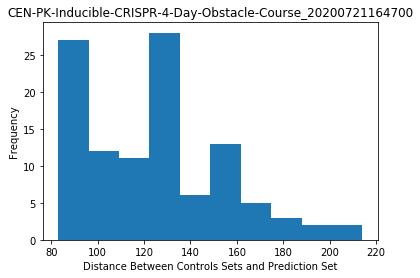

In [10]:
plt.hist(w5.values())
plt.title('CEN-PK-Inducible-CRISPR-4-Day-Obstacle-Course_20200721164700')
plt.xlabel('Distance Between Controls Sets and Prediction Set')
plt.ylabel('Frequency')

In [ ]:
plt.hist(w4.values())
plt.title('YeastSTATES-OR-Gate-CRISPR-Dose-Response_20200625204022')
plt.xlabel('Distance Between Controls Sets and Prediction Set')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

Text(0, 0.5, 'Frequency')

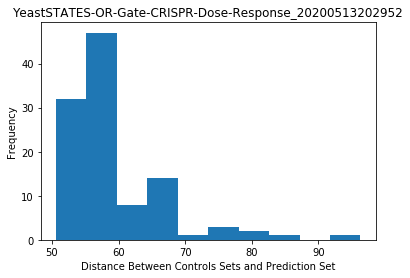

In [17]:
import matplotlib.pyplot as plt

plt.hist(w1.values())
plt.title('YeastSTATES-OR-Gate-CRISPR-Dose-Response_20200513202952')
plt.xlabel('Distance Between Controls Sets and Prediction Set')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

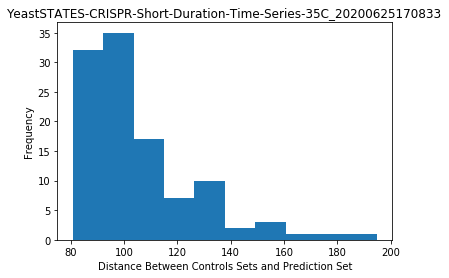

In [18]:
plt.hist(w2.values())
plt.title('YeastSTATES-CRISPR-Short-Duration-Time-Series-35C_20200625170833')
plt.xlabel('Distance Between Controls Sets and Prediction Set')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

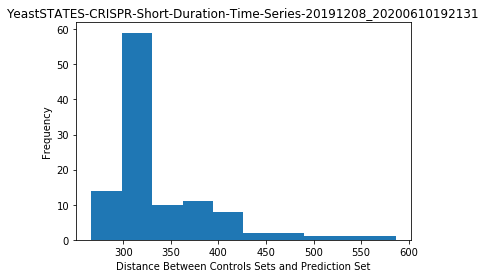

In [19]:
plt.hist(w3.values())
plt.title('YeastSTATES-CRISPR-Short-Duration-Time-Series-20191208_20200610192131')
plt.xlabel('Distance Between Controls Sets and Prediction Set')
plt.ylabel('Frequency')